# Sinter integration

To enable circuit level noise decoding, the BPOSD and BeliefFind decoders are integrated with the Sinter module of [Stim](https://github.com/quantumlib/Stim/tree/main).
[Sinter](https://github.com/quantumlib/Stim/tree/main/glue/sample) is a software tool/library for doing fast monte carlo sampling of quantum error correction circuits. 
This notebook shows how to obtain a threshold using the BPOSD and BeliefFind decoders.

## Generate the circuits

We'll use the surface code circuits which are built-in to stim.

In [12]:
import sinter
import stim
import numpy as np 
from ldpc.sinter_decoders import SinterBeliefFindDecoder, SinterBpOsdDecoder
from matplotlib import pyplot as plt
import numpy as np

def generate_example_tasks():
    for p in np.arange(0.001, 0.01, 0.002):
        for d in [5, 7, 9]:
            sc_circuit = stim.Circuit.generated(
                rounds=d,
                distance=d,
                after_clifford_depolarization=p,
                after_reset_flip_probability=p,
                before_measure_flip_probability=p,
                before_round_data_depolarization=p,
                code_task=f'surface_code:rotated_memory_z',
            )
            yield sinter.Task(
                circuit=sc_circuit,
                json_metadata={
                    'p': p,
                    'd': d,
                    'rounds': d,
                },
            )



## Run simulations
In the function sinter.collect we pass the SinterBpOsdDecoder and SinterBeliefFindDecoder. For details on which parameters these decoders accept take a look at [ldpc/sinter_decoders](ldpc/sinter_decoders.rst)


In [13]:
def run_simulation():
    samples = sinter.collect(
        num_workers=10,
        max_shots=20_000,
        max_errors=100,
        tasks=generate_example_tasks(),
        decoders=['bposd', 'belief_find'],
        custom_decoders={'bposd': SinterBpOsdDecoder(
            max_iter=5,
            bp_method="ms",
            ms_scaling_factor=0.625,
            schedule="parallel",
            osd_method="osd0"),
            "belief_find": SinterBeliefFindDecoder(max_iter=5,
                                                   bp_method="ms",
                                                   ms_scaling_factor=0.625,
                                                   schedule="parallel")},

        print_progress=True,
        save_resume_filepath=f'bposd_surface_code.csv',
    )
    return(samples)

In [14]:
samples=run_simulation()

Starting 10 workers...
Running...
    belief_find processes=1  ~core_mins_left=None    (initializing...) {d=7,p=0.001,rounds=7}
          bposd processes=1  ~core_mins_left=None    (initializing...) {d=9,p=0.001,rounds=9}
    belief_find processes=1  ~core_mins_left=None    (initializing...) {d=9,p=0.001,rounds=9}
          bposd processes=1  ~core_mins_left=None    (initializing...) {d=5,p=0.003,rounds=5}
    belief_find processes=1  ~core_mins_left=None    (initializing...) {d=5,p=0.003,rounds=5}
          bposd processes=1  ~core_mins_left=None    (initializing...) {d=7,p=0.003,rounds=7}
    belief_find processes=1  ~core_mins_left=None    (initializing...) {d=7,p=0.003,rounds=7}
          bposd processes=1  ~core_mins_left=None    (initializing...) {d=9,p=0.003,rounds=9}
    belief_find processes=1  ~core_mins_left=None    (initializing...) {d=9,p=0.003,rounds=9}
          bposd processes=1  ~core_mins_left=None    (initializing...) {d=5,p=0.005,rounds=5}
Done collecting


## Print and plot results

In [19]:
def print_results(samples):
 # Print samples as CSV data.
    print(sinter.CSV_HEADER)
    for sample in samples:
        print(sample.to_csv_line())

def plot_results(samples):
    # Render a matplotlib plot of the data.
    fig, axis = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
    sinter.plot_error_rate(
        ax=axis[0],
        stats=samples,
        group_func=lambda stat: f"Rotated Surface Code d={stat.json_metadata['d']}",
        filter_func=lambda stat: stat.decoder == 'bposd',
        x_func=lambda stat: stat.json_metadata['p'],
    )

    sinter.plot_error_rate(
        ax=axis[1],
        stats=samples,
        group_func=lambda stat: f"Rotated Surface Code d={stat.json_metadata['d']}",
        filter_func=lambda stat: stat.decoder == 'belief_find',
        x_func=lambda stat: stat.json_metadata['p'],
    )
    axis[0].set_ylabel('Logical Error Rate')
    axis[0].set_title('BPOSD')
    axis[1].set_title('Belief Find')
    for ax in axis:
        ax.loglog()
        ax.grid()
        ax.set_xlabel('Physical Error Rate')
        ax.legend()

    # Save to file and also open in a window.
    fig.savefig('plot.png')
    plt.show()

In [20]:
print_results(samples)


     shots,    errors,  discards, seconds,decoder,strong_id,json_metadata,custom_counts
     20000,         1,         0,    54.5,bposd,0303a22be9c90e4634d6ed94e1115e4012a95cd8a1b9979245877e9feaf1effc,"{""d"":5,""p"":0.001,""rounds"":5}",
     20000,        18,         0,    22.8,bposd,bcd97b8394ac1d9f7f140a7a9737f5779c2b2029334c730707b1a9f71f2ce583,"{""d"":5,""p"":0.002,""rounds"":5}",
     20000,        63,         0,    30.7,bposd,a6afccb7294493f5ebb587a4c0f1846a65cb089d9735ad505939fff73351089c,"{""d"":5,""p"":0.003,""rounds"":5}",
     18368,       105,         0,    41.3,bposd,13b5f4352a9615f6f77853cf7cde4f2081e5fd2292112fcb79b062c3c1e6f657,"{""d"":5,""p"":0.004,""rounds"":5}",
     20000,         0,         0,   206.5,bposd,0e10ed2d206f476850b002e6e2c1e74f86e5ab874b0fb9cb7b34979d21f7660d,"{""d"":7,""p"":0.001,""rounds"":7}",
     20000,        10,         0,   250.1,bposd,3e4aa306938156ae3b36d57877a5854dceafb973cb156e5c8b757172e03a8ee6,"{""d"":7,""p"":0.002,""rounds"":7}",
     2

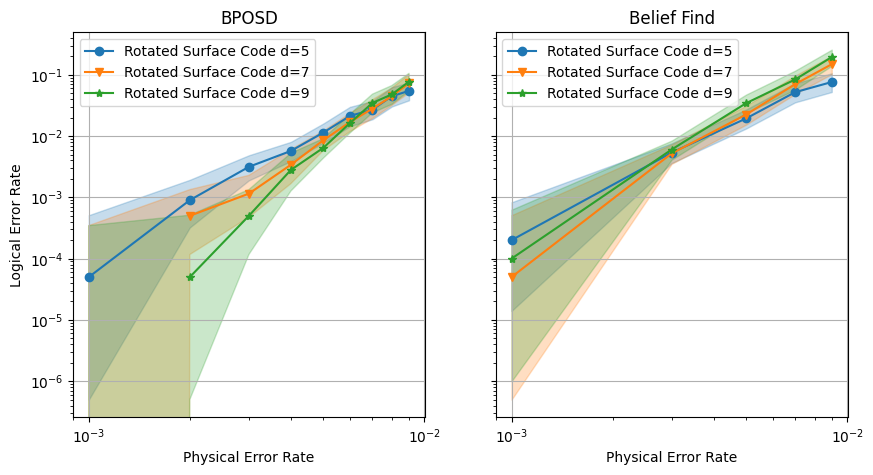

In [21]:
plot_results(samples)